In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
import lightgbm
from xgboost import XGBClassifier
import seaborn as sns
import optuna

from fraud_detection.utils import save_pickle_dataset, load_pickle_dataset, display_model_result, plot_confusion_matrix, get_pipeline, display_model_score
from fraud_detection.config import DATA_DIR, DATA_FILENAME_CSV, DATA_FILENAME_PICKLE, DATA_PICKLE_PATH, DATA_CSV_PATH

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if Path(DATA_PICKLE_PATH).exists():
    print("⏳ Load dataset from pickle")
    data = load_pickle_dataset()
    print("✅ Data loaded")
else:
    print("⏳ Loading dataset from csv")
    data = pd.read_csv(f"{DATA_CSV_PATH}")
    print("✅ Data loaded")
    
    print("⏳ Saving dataset to pickle file")
    save_pickle_dataset(data)
    print("✅ Data Saved")

⏳ Load dataset from pickle
✅ Data loaded


In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.shape

(6362620, 11)

**Description of transaction types**

CASH_OUT: Withdrawal of funds from an account in the form of physical cash.

PAYMENT: Act of transferring funds from one party to another in exchange for goods or services via cash, cheques, credit cards.

CASH_IN: Depositing physical cash into an account.

TRANSFER: Moving funds from one account to another.

DEBIT: Transaction where funds are deducted from an account through a debit card transaction.

In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
#Dropping the 'isFlaggedFraud' feature. Not required as we have 'isFraud' feature to predict fraudulous transactions
data.drop('isFlaggedFraud', axis=1, inplace=True)

In [9]:
#Statistics of dataset
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [10]:
#How many records are there for each transaction type?
data.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [11]:
# Percentage
data.type.value_counts(normalize=True)

type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: float64

In [12]:
data['nameOrig'].unique().size

6353307

In [13]:
data.groupby(by=['nameOrig'])['isFraud'].sum().sort_values(ascending=False)

nameOrig
C1998644906    1
C43271707      1
C2052061131    1
C1521962059    1
C853796614     1
              ..
C164527924     0
C16452791      0
C164527901     0
C164527882     0
C999999784     0
Name: isFraud, Length: 6353307, dtype: int64

In [14]:
data.groupby(by=['nameDest'])['isFraud'].sum().sort_values(ascending=False)

nameDest
C1366192319    2
C1460854172    2
C1193568854    2
C650699445     2
C505532836     2
              ..
M1306254708    0
M1306255313    0
M1306255439    0
M1306255621    0
M999999784     0
Name: isFraud, Length: 2722362, dtype: int64

In [15]:
data.groupby(by=['nameOrig', 'nameDest'])['isFraud'].sum().sort_values(ascending=False)

nameOrig     nameDest   
C344825727   C997289329     1
C1184786020  C1519560642    1
C193359947   C1492417626    1
C1503196403  C448117484     1
C1558861751  C939990653     1
                           ..
C1645281020  C1360422976    0
C1645281014  M670437393     0
C1645280609  C1548802752    0
C1645279448  C1890730800    0
C999999784   C1952034932    0
Name: isFraud, Length: 6362620, dtype: int64

In [16]:
data.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [17]:
data.isFraud.value_counts(normalize=True) * 100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

<Axes: xlabel='isFraud'>

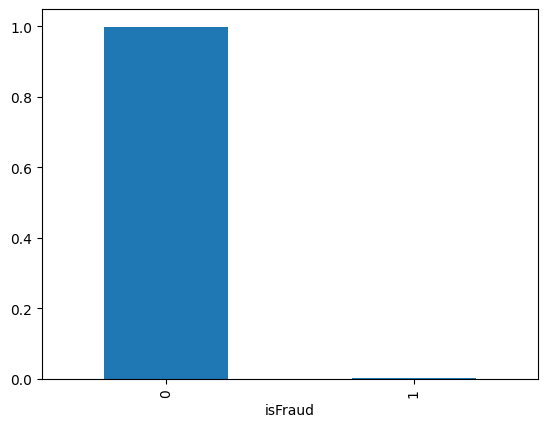

In [18]:
# Plot number of fraud entries
data.isFraud.value_counts(normalize=True).plot(kind='bar')

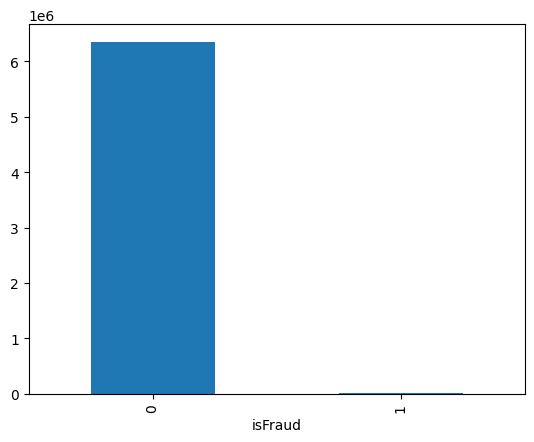

In [19]:
# Plot numbers of isFraud entries by nameDest
data.groupby('isFraud')['nameDest'].count().plot(kind='bar')
plt.show()

In [20]:
# Plot numbers of isFraud entries by nameDest
fraud_data_more_than_1 =  data[data['isFraud'] == 1][['nameDest', 'isFraud']]\
.groupby('nameDest')\
.count()\
.sort_values(by='isFraud', ascending=False)

In [21]:
fraud_data_more_than_1.size

8169

In [22]:
fraud_data_more_than_1[fraud_data_more_than_1['isFraud'] > 1].size

44

In [23]:
(44 / 8169) * 100

0.538621618313135

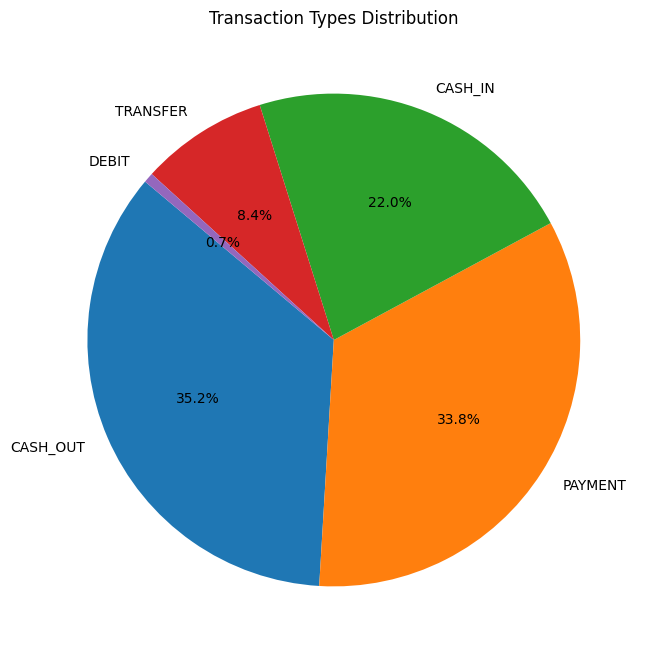

In [23]:
plt.figure(figsize=(8, 8))
type_counts=data.type.value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transaction Types Distribution')
plt.show()

In [25]:
data[data['isFraud'] == 1].groupby('type')['isFraud'].count()

type
CASH_OUT    4116
TRANSFER    4097
Name: isFraud, dtype: int64

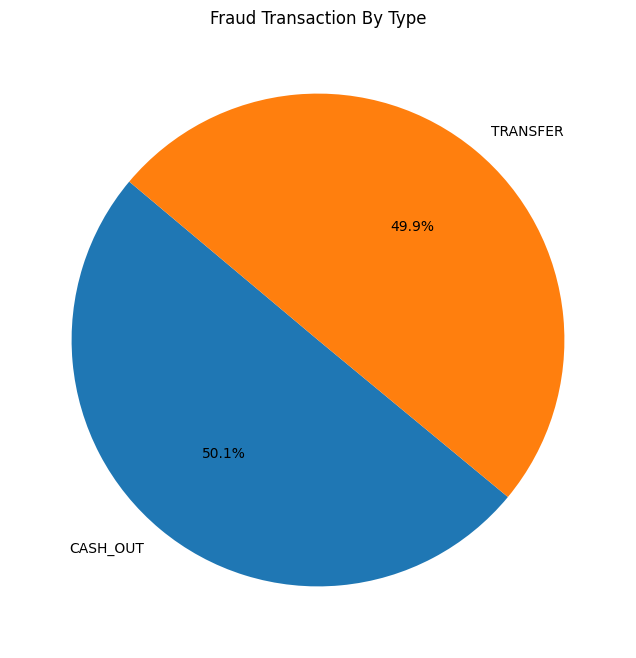

In [26]:
plt.figure(figsize=(8, 8))
fraud_data_by_type = data[data['isFraud'] == 1].groupby('type')['isFraud'].count()
plt.pie(fraud_data_by_type, labels=fraud_data_by_type.index, autopct='%1.1f%%', startangle=140)
plt.title('Fraud Transaction By Type')
plt.show()

35.2% of transaction types are Cash out and 33.8% are Payment

/var/folders/46/yy2622n97qg2hyp5b8v44khr0000gp/T/ipykernel_49257/452186433.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  transaction_type=pd.value_counts(data['type'],sort = True)


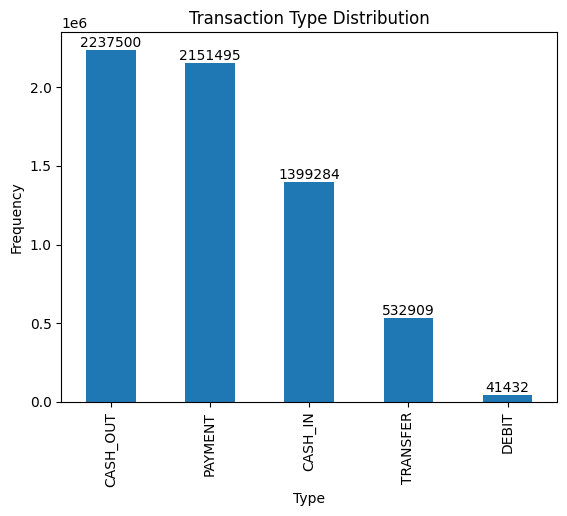

In [27]:
transaction_type=pd.value_counts(data['type'],sort = True)
number_of_transactions=transaction_type.plot(kind='bar')
plt.title('Transaction Type Distribution')
plt.xlabel('Type')
plt.ylabel('Frequency')
for i, count in enumerate(transaction_type):
    number_of_transactions.text(i, count + 0.05, str(count), ha='center', va='bottom')

In [28]:
# Correlation
numeric_data = data.select_dtypes(include=['number'])
numeric_data.corr()['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

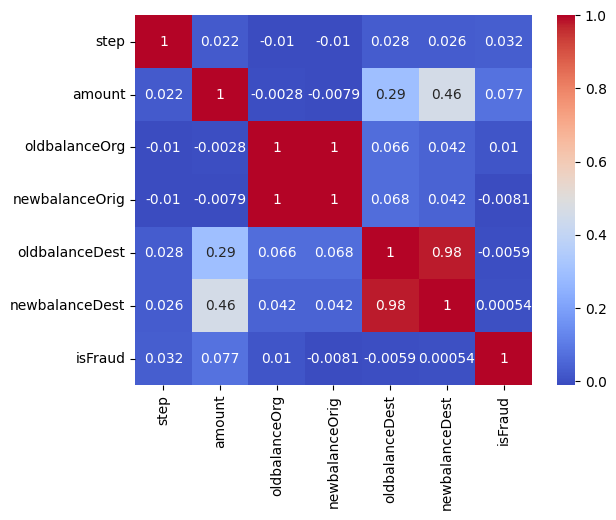

In [29]:
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.show()

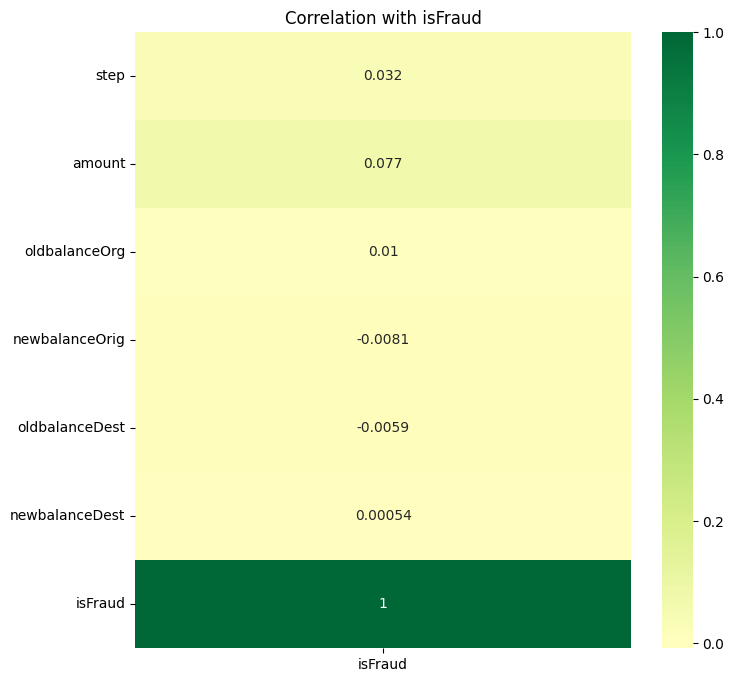

In [30]:
# Correlation with isFraud
corr = numeric_data.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr[['isFraud']], annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation with isFraud')
plt.show()

In [31]:
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1


In [4]:
X = data.drop(columns=['step', 'nameOrig', 'nameDest', 'isFraud'])
y = data['isFraud']

In [5]:
# Data splitting (Train = 0.8, test = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 7), (1272524, 7), (5090096,), (1272524,))

In [6]:
# Encoding dataset
category_transformer = OneHotEncoder(drop='if_binary')
numeric_transformer = make_pipeline(StandardScaler())

In [7]:
# Prepross pipline
preproc = make_column_transformer(
	(category_transformer, make_column_selector(dtype_include=[object, bool])),
	(numeric_transformer, make_column_selector(dtype_exclude=[object, bool])),
	remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17e94ffa0>),
                                ('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17e94ee30>)])

## Logistic Regression

### 1. Training

In [36]:
# Define model
model = LogisticRegression(max_iter=1000)
pipline = get_pipeline(preproc, model)
pipline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))],
         verbose=True)

In [37]:
pipline.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.6s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   4.4s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))],
         verbose=True)

0.9991499178011574

[[5083141     362]
 [   3965    2628]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.88      0.40      0.55      6593

    accuracy                           1.00   5090096
   macro avg       0.94      0.70      0.77   5090096
weighted avg       1.00      1.00      1.00   5090096



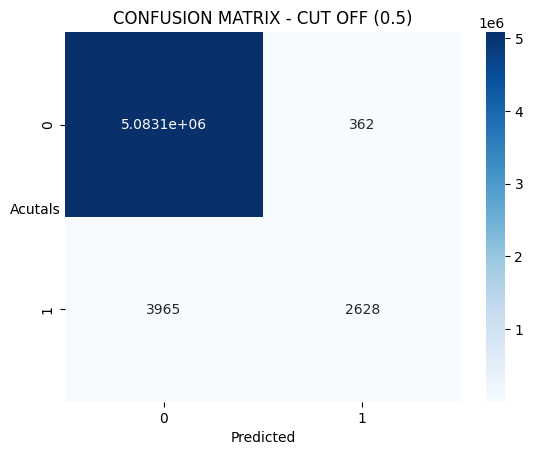

In [41]:
y_train_predict = pipline.predict(X_train)
score = pipline.score(X_train, y_train)
pipline.score(X_train, y_train)
display_model_result(y_train, y_train_predict, score)
plot_confusion_matrix(y_train, y_train_predict)

### 2. Testing

In [87]:
y_test_predict = pipline.predict(X_test)

In [89]:
log_reg_evaluation = display_model_score(y_train, y_train_predict, y_test, y_test_predict, 'Logistic Reg.')
log_reg_evaluation

,train,test
Model,Logistic Reg.,Logistic Reg.
Accuracy,99.914992,99.914343
Precision,87.892977,87.323944
Recall,39.860458,38.271605


### Test model

In [40]:
data_test = pd.DataFrame([{'type':'PAYMENT',
                          'amount': 1000.0,
                          'oldbalanceOrg': 4000.00,
                          'newbalanceOrig': 2000.00,
                          'oldbalanceDest': 100.00,
                          'newbalanceDest': 200.00}])
print(data_test)
pipline.predict(data_test)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,1000.0,4000.0,2000.0,100.0,200.0


## Gaussian Naive Bayes

### 1. Model

In [45]:
nb_model = GaussianNB()
nb_pipe = get_pipeline(nb_model, preproc)
nb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('gaussiannb', GaussianNB())],
         verbose=True)

### 2. Training

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.5s
[Pipeline] ........ (step 2 of 2) Processing gaussiannb, total=   1.0s
0.5657398210171282

[[2873077 2210426]
 [      0    6593]]

              precision    recall  f1-score   support

           0       1.00      0.57      0.72   5083503
           1       0.00      1.00      0.01      6593

    accuracy                           0.57   5090096
   macro avg       0.50      0.78      0.36   5090096
weighted avg       1.00      0.57      0.72   5090096



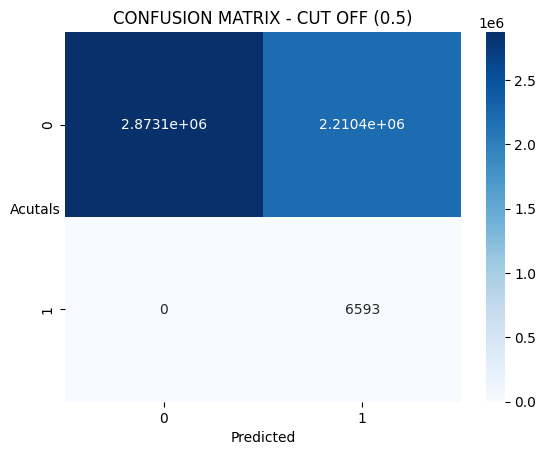

In [46]:
nb_pipe.fit(X_train, y_train)
nb_y_train_predict = nb_pipe.predict(X_train)
nb_score = nb_pipe.score(X_train, y_train)
display_model_result(y_train, nb_y_train_predict, nb_score)
plot_confusion_matrix(y_train, nb_y_train_predict)

### 2. Testing

0.566401891044884

[[719140 551764]
 [     0   1620]]

              precision    recall  f1-score   support

           0       1.00      0.57      0.72   1270904
           1       0.00      1.00      0.01      1620

    accuracy                           0.57   1272524
   macro avg       0.50      0.78      0.36   1272524
weighted avg       1.00      0.57      0.72   1272524



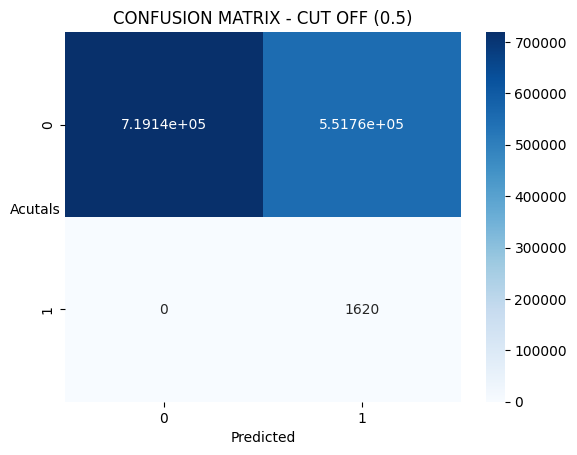

In [47]:
nb_y_test_predict = nb_pipe.predict(X_test)
nb_test_score = nb_pipe.score(X_test, y_test)
# display_model_result(y_test, nb_y_test_predict, nb_test_score)
plot_confusion_matrix(y_test, nb_y_test_predict)

In [90]:
nb_evaluation = display_model_score(y_train, nb_y_train_predict, y_test, nb_y_test_predict, 'Naive Bayes')
nb_evaluation

,train,test
Model,Naive Bayes,Naive Bayes
Accuracy,56.573982,56.640189
Precision,0.297381,0.292744
Recall,100.0,100.0


## Decision Tree Classifier

### 1. Training

In [51]:
dt_model = tree.DecisionTreeClassifier()
dt_pipe = get_pipeline(dt_model, preproc)
dt_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('decisiontreeclassifier', DecisionTreeClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.6s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=  20.3s
1.0

[[5083503       0]
 [      0    6593]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096



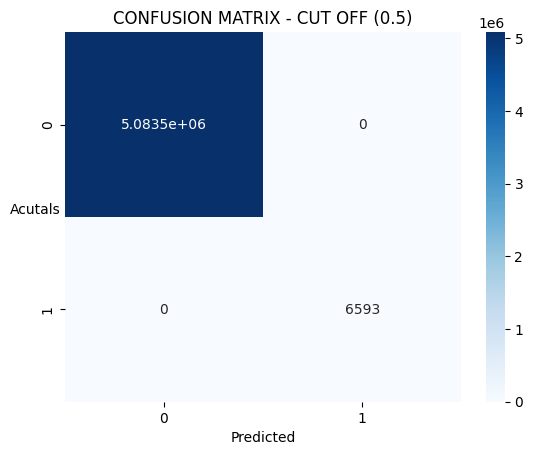

In [52]:
dt_pipe.fit(X_train, y_train)
dt_y_train_predict = dt_pipe.predict(X_train)
dt_score = dt_pipe.score(X_train, y_train)
display_model_result(y_train, dt_y_train_predict, dt_score)
plot_confusion_matrix(y_train, dt_y_train_predict)

### 2. Testing

0.9997634622215377

[[1270759     145]
 [    156    1464]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.91      0.90      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.95      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



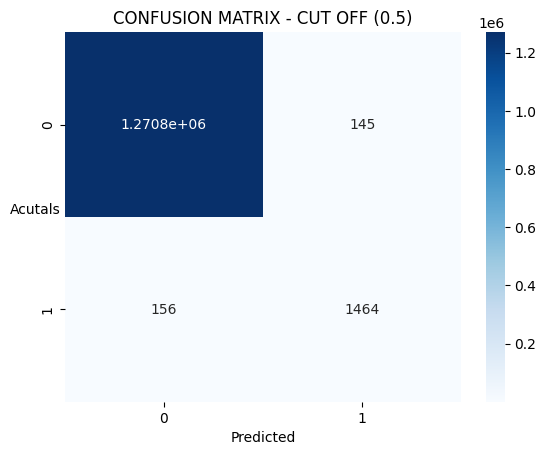

In [53]:
dt_y_test_predict = dt_pipe.predict(X_test)
dt_test_score = dt_pipe.score(X_test, y_test)
display_model_result(y_test, dt_y_test_predict, dt_test_score)
plot_confusion_matrix(y_test, dt_y_test_predict)

In [85]:
dt_evaluation = display_model_score(y_train, dt_y_train_predict, y_test, dt_y_test_predict, 'Decision Tree')
dt_evaluation

,train,test
Model,Decision Tree,Decision Tree
Accuracy,100.0,99.976346
Precision,100.0,90.988191
Recall,100.0,90.37037


## Random Forest

### 1. Training

In [55]:
rf_model = RandomForestClassifier()
rf_pipe = get_pipeline(rf_model, preproc)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('randomforestclassifier', RandomForestClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.7s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=11.1min
0.9999996070801023

[[5083503       0]
 [      2    6591]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096



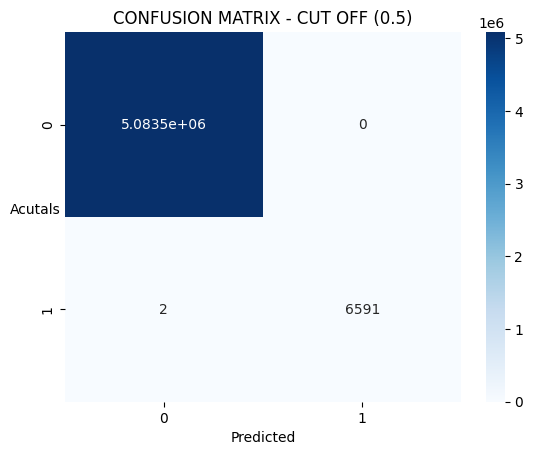

In [56]:
rf_pipe.fit(X_train, y_train)
rf_y_train_predict = rf_pipe.predict(X_train)
rf_score = rf_pipe.score(X_train, y_train)
display_model_result(y_train, rf_y_train_predict, rf_score)
plot_confusion_matrix(y_train, rf_y_train_predict)

### 2. Testing

0.9997634622215377

[[1270853      51]
 [    331    1289]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.80      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



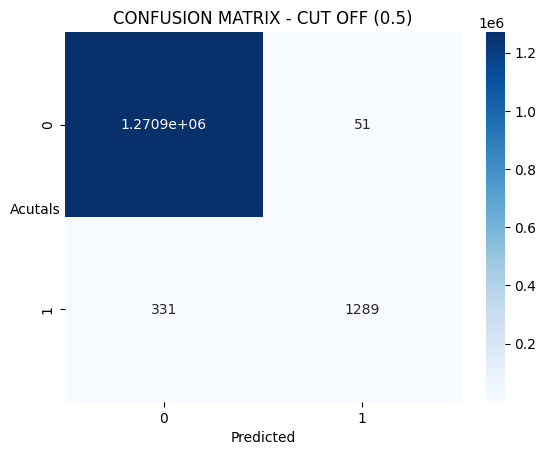

In [58]:
rf_y_test_predict = rf_pipe.predict(X_test)
rf_test_score = rf_pipe.score(X_test, y_test)
display_model_result(y_test, rf_y_test_predict, dt_test_score)
plot_confusion_matrix(y_test, rf_y_test_predict)

In [84]:
rf_evaluation = display_model_score(y_train, rf_y_train_predict, y_test, rf_y_test_predict, 'Random Forest')
rf_evaluation

,train,test
Model,Random Forest,Random Forest
Accuracy,99.999961,99.969981
Precision,100.0,96.19403
Recall,99.969665,79.567901


## XGBClassifier model training

### 1. Model training

In [75]:
xgb_model = XGBClassifier()
xgb_pipe = get_pipeline(xgb_model, preproc)
xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.6s
[Pipeline] ..... (step 2 of 2) Processing xgbclassifier, total=   8.0s
0.9997114003350821

[[5083355     148]
 [   1321    5272]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.97      0.80      0.88      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.90      0.94   5090096
weighted avg       1.00      1.00      1.00   5090096



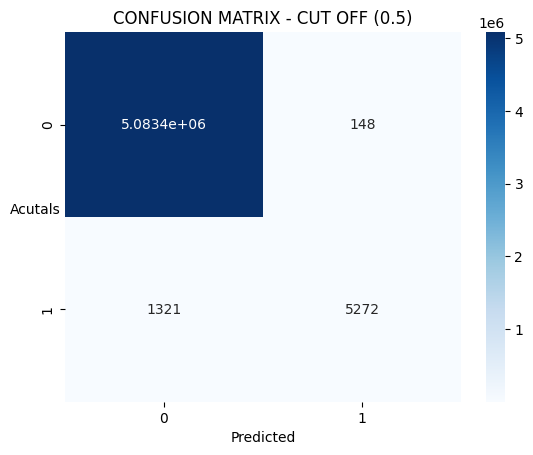

In [76]:
xgb_pipe.fit(X_train, y_train)
xgb_y_train_predict = xgb_pipe.predict(X_train)
xgb_score = xgb_pipe.score(X_train, y_train)
display_model_result(y_train, xgb_y_train_predict, xgb_score)
plot_confusion_matrix(y_train, xgb_y_train_predict)

### 2. Model testing

0.9996707331256621

[[1270841      63]
 [    356    1264]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.95      0.78      0.86      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



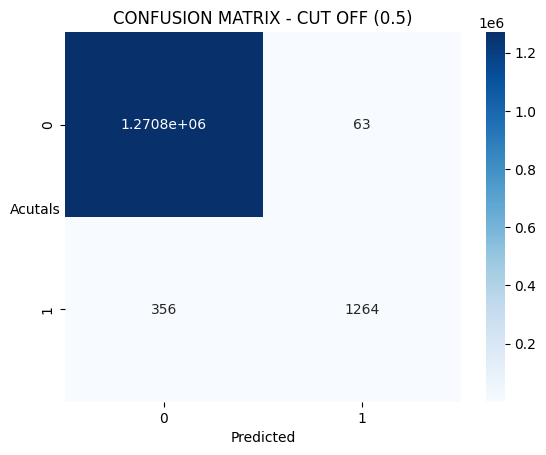

In [77]:
xgb_y_test_predict = xgb_pipe.predict(X_test)
xgb_test_score = xgb_pipe.score(X_test, y_test)
display_model_result(y_test, xgb_y_test_predict, xgb_test_score)
plot_confusion_matrix(y_test, xgb_y_test_predict)

In [83]:
xgb_evaluation = display_model_score(y_train, xgb_y_train_predict, y_test, xgb_y_test_predict, 'XGB Classifier')
xgb_evaluation

,train,test
Model,XGB Classifier,XGB Classifier
Accuracy,99.97114,99.967073
Precision,97.269373,95.252449
Recall,79.963598,78.024691


## AdaBoostClassifier

### 1. Training

In [122]:
adb_model = AdaBoostClassifier()
adb_pipe = get_pipeline(adb_model, preproc)
adb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('adaboostclassifier', AdaBoostClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.0s


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing adaboostclassifier, total= 3.7min
0.9993589511867753

[[5083022     481]
 [   2782    3811]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.89      0.58      0.70      6593

    accuracy                           1.00   5090096
   macro avg       0.94      0.79      0.85   5090096
weighted avg       1.00      1.00      1.00   5090096



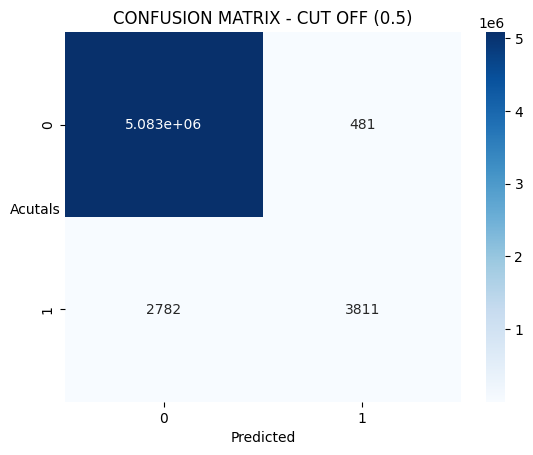

In [123]:
adb_pipe.fit(X_train, y_train)
adb_y_train_predict = adb_pipe.predict(X_train)
adb_score = adb_pipe.score(X_train, y_train)
display_model_result(y_train, adb_y_train_predict, adb_score)
plot_confusion_matrix(y_train, adb_y_train_predict)

### 2. Testing

0.9993697564839642

[[1270789     115]
 [    687     933]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.58      0.70      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.79      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



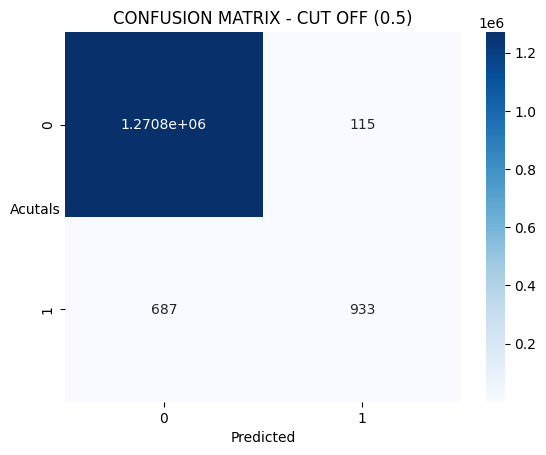

In [124]:
adb_y_test_predict = adb_pipe.predict(X_test)
adb_test_score = adb_pipe.score(X_test, y_test)
display_model_result(y_test, adb_y_test_predict, adb_test_score)
plot_confusion_matrix(y_test, adb_y_test_predict)

### 3. Evaluation

In [125]:
adb_evaluation = display_model_score(y_train, adb_y_train_predict, y_test, adb_y_test_predict, 'Adaboosting Classifier')
adb_evaluation

,train,test
Model,Adaboosting Classifier,Adaboosting Classifier
Accuracy,99.935895,99.936976
Precision,88.793103,89.026718
Recall,57.803731,57.592593


## Bagging Classifier

### 1. Training

In [126]:
bag_model = BaggingClassifier()
bag_pipe = get_pipeline(bag_model, preproc)
bag_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('baggingclassifier', BaggingClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.7s
[Pipeline] . (step 2 of 2) Processing baggingclassifier, total= 3.2min
0.99997878232552

[[5083497       6]
 [    102    6491]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      0.98      0.99      6593

    accuracy                           1.00   5090096
   macro avg       1.00      0.99      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096



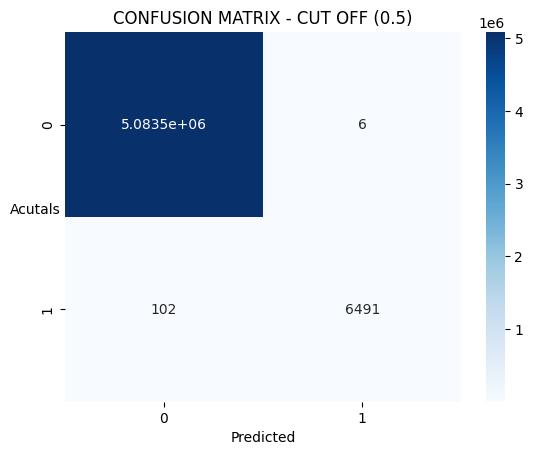

In [127]:
bag_pipe.fit(X_train, y_train)
bag_y_train_predict = bag_pipe.predict(X_train)
bag_score = bag_pipe.score(X_train, y_train)
display_model_result(y_train, bag_y_train_predict, bag_score)
plot_confusion_matrix(y_train, bag_y_train_predict)

### 2. Testing

0.9997760356582666

[[1270814      90]
 [    195    1425]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.88      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.94      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



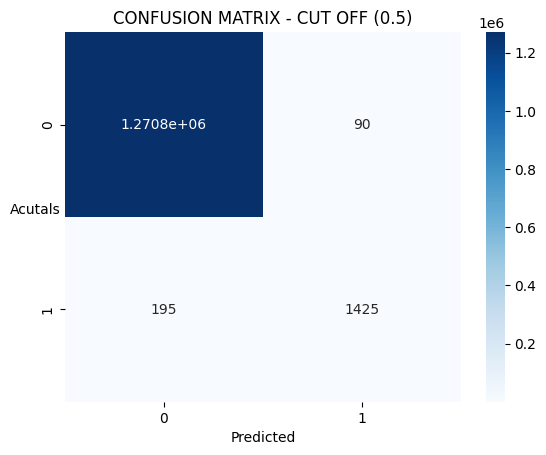

In [128]:
bag_y_test_predict = bag_pipe.predict(X_test)
bag_test_score = bag_pipe.score(X_test, y_test)
display_model_result(y_test, bag_y_test_predict, bag_test_score)
plot_confusion_matrix(y_test, bag_y_test_predict)

### 3. Evaluation

In [129]:
bag_evaluation = display_model_score(y_train, bag_y_train_predict, y_test, bag_y_test_predict, 'Bagging Classifier')
bag_evaluation

,train,test
Model,Bagging Classifier,Bagging Classifier
Accuracy,99.997878,99.977604
Precision,99.90765,94.059406
Recall,98.452905,87.962963


## GradientBoostingClassifier

### 1. Training

In [130]:
gbc_model = GradientBoostingClassifier()
gbc_pipe = get_pipeline(gbc_model, preproc)
gbc_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.9s
[Pipeline]  (step 2 of 2) Processing gradientboostingclassifier, total=16.5min
0.9990102347774973

[[5082352    1151]
 [   3887    2706]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.70      0.41      0.52      6593

    accuracy                           1.00   5090096
   macro avg       0.85      0.71      0.76   5090096
weighted avg       1.00      1.00      1.00   5090096



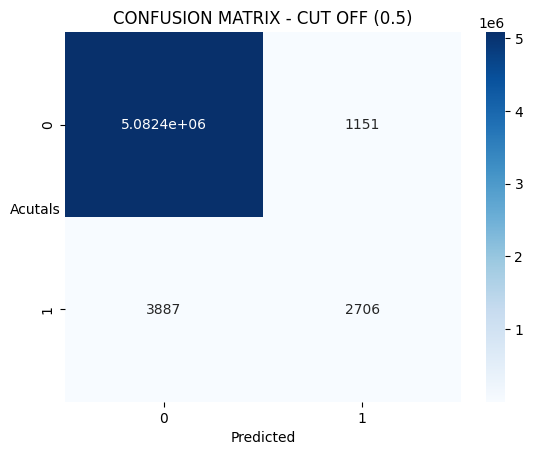

In [131]:
gbc_pipe.fit(X_train, y_train)
gbc_y_train_predict = gbc_pipe.predict(X_train)
gbc_score = gbc_pipe.score(X_train, y_train)
display_model_result(y_train, gbc_y_train_predict, gbc_score)
plot_confusion_matrix(y_train, gbc_y_train_predict)

### 2. Testing

0.9990459904881951

[[1270633     271]
 [    943     677]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.71      0.42      0.53      1620

    accuracy                           1.00   1272524
   macro avg       0.86      0.71      0.76   1272524
weighted avg       1.00      1.00      1.00   1272524



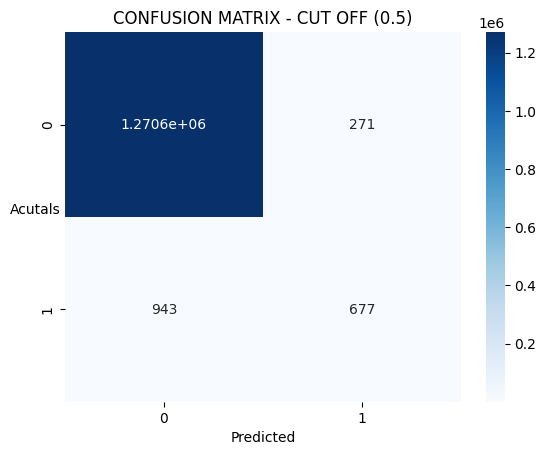

In [132]:
gbc_y_test_predict = gbc_pipe.predict(X_test)
gbc_test_score = gbc_pipe.score(X_test, y_test)
display_model_result(y_test, gbc_y_test_predict, gbc_test_score)
plot_confusion_matrix(y_test, gbc_y_test_predict)

### 3. Evaluation

In [133]:
gbc_evaluation = display_model_score(y_train, gbc_y_train_predict, y_test, gbc_y_test_predict, 'GradientBoosting Classifier')
gbc_evaluation

,train,test
Model,GradientBoosting Classifier,GradientBoosting Classifier
Accuracy,99.901023,99.904599
Precision,70.158154,71.413502
Recall,41.043531,41.790123


## LightGBM

In [162]:
from lightgbm import  LGBMClassifier
lgbm_model = LGBMClassifier()
lgbm_pipe = get_pipeline(lgbm_model, preproc)
lgbm_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('lgbmclassifier', LGBMClassifier())],
         verbose=True)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   2.4s
[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001295 -> initscore=-6.647747
[LightGBM] [Info] Start training from score -6.647747
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=   5.8s
0.9985705574118838

[[5078610    4893]
 [   2383    4210]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.46      0.64      0.54      6593

    accuracy                           1.00   5090096
   macro avg       

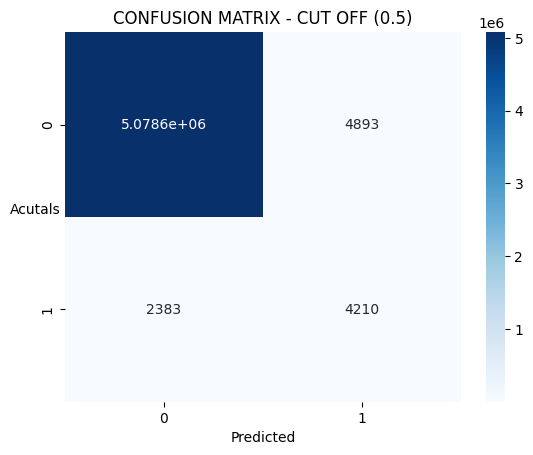

In [163]:
lgbm_pipe.fit(X_train, y_train)
lgbm_y_train_predict = lgbm_pipe.predict(X_train)
lgbm_score = lgbm_pipe.score(X_train, y_train)
display_model_result(y_train, lgbm_y_train_predict, lgbm_score)
plot_confusion_matrix(y_train, lgbm_y_train_predict)

0.9985296937425149

[[1269635    1269]
 [    602    1018]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.45      0.63      0.52      1620

    accuracy                           1.00   1272524
   macro avg       0.72      0.81      0.76   1272524
weighted avg       1.00      1.00      1.00   1272524



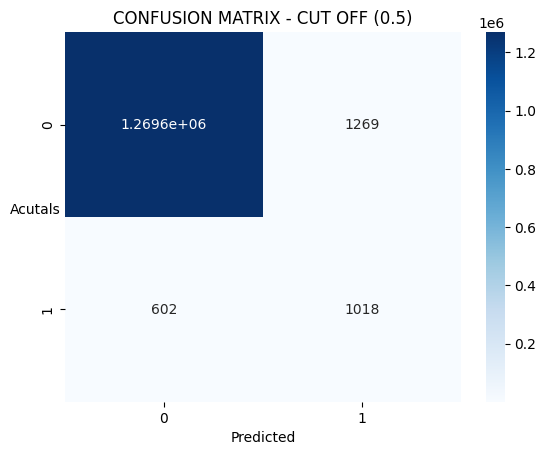

In [164]:
lgbm_y_test_predict = lgbm_pipe.predict(X_test)
lgbm_test_score = lgbm_pipe.score(X_test, y_test)
display_model_result(y_test, lgbm_y_test_predict, lgbm_test_score)
plot_confusion_matrix(y_test, lgbm_y_test_predict)

In [165]:
lgbm_evaluation = display_model_score(y_train, lgbm_y_train_predict, y_test, lgbm_y_test_predict, 'LightGBM Classifier')
lgbm_evaluation

,train,test
Model,LightGBM Classifier,LightGBM Classifier
Accuracy,99.857056,99.852969
Precision,46.24849,44.512462
Recall,63.855604,62.839506


## Evaluation Summary

In [166]:
model_evaluation = pd.concat([log_reg_evaluation, nb_evaluation, dt_evaluation, rf_evaluation, xgb_evaluation, adb_evaluation, bag_evaluation, gbc_evaluation, lgbm_evaluation], ignore_index=True, axis=1)
# .melt(id_vars=['train', 'test'], value_vars=['Model', 'Accuracy', 'Precision', 'Recall'])
model_evaluation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Model,Logistic Reg.,Logistic Reg.,Naive Bayes,Naive Bayes,Decision Tree,Decision Tree,Random Forest,Random Forest,XGB Classifier,XGB Classifier,Adaboosting Classifier,Adaboosting Classifier,Bagging Classifier,Bagging Classifier,GradientBoosting Classifier,GradientBoosting Classifier,LightGBM Classifier,LightGBM Classifier
Accuracy,99.914992,99.914343,56.573982,56.640189,100.0,99.976346,99.999961,99.969981,99.97114,99.967073,99.935895,99.936976,99.997878,99.977604,99.901023,99.904599,99.857056,99.852969
Precision,87.892977,87.323944,0.297381,0.292744,100.0,90.988191,100.0,96.19403,97.269373,95.252449,88.793103,89.026718,99.90765,94.059406,70.158154,71.413502,46.24849,44.512462
Recall,39.860458,38.271605,100.0,100.0,100.0,90.37037,99.969665,79.567901,79.963598,78.024691,57.803731,57.592593,98.452905,87.962963,41.043531,41.790123,63.855604,62.839506


# Fine turned

In [41]:
def objective(trial):
    param = {
        'objective': 'binary',
        'verbosity': -1,
        'is_unbalanced': True,
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = lightgbm.LGBMClassifier(**param)
    pipline = get_pipeline(model, preproc)
    score = cross_val_score(pipline, X_train, y_train, scoring='recall', n_jobs=-1, cv=5)
    
    
    return score.mean()
    

In [43]:
# es = lightgbm.early_stopping(20)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-06-20 05:49:23,838] A new study created in memory with name: no-name-00a2e921-4541-4604-89b6-745c3b3abed7


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.3s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   5.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   6.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   6.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   7.2s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  55.3s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  57.5s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  59.1s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  58.2s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  57.3s


[I 2024-06-20 05:50:40,062] Trial 0 finished with value: 0.7726403296745017 and parameters: {'num_leaves': 211, 'feature_fraction': 0.9808638484699832, 'bagging_fraction': 0.9692696623244861, 'learning_rate': 0.028583061178554824, 'bagging_freq': 2, 'max_depth': 10, 'min_child_samples': 53}. Best is trial 0 with value: 0.7726403296745017.


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.6s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  20.6s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  20.9s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  20.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  20.9s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  23.3s


[I 2024-06-20 05:51:11,780] Trial 1 finished with value: 0.4981078459908355 and parameters: {'num_leaves': 31, 'feature_fraction': 0.8943932633524141, 'bagging_fraction': 0.4394942886291253, 'learning_rate': 0.072731526562164, 'bagging_freq': 3, 'max_depth': 18, 'min_child_samples': 67}. Best is trial 0 with value: 0.7726403296745017.


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.6s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   5.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  22.9s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  23.5s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  25.0s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  24.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  23.5s


[I 2024-06-20 05:51:46,923] Trial 2 finished with value: 0.5575640717377974 and parameters: {'num_leaves': 48, 'feature_fraction': 0.5435468872845188, 'bagging_fraction': 0.4493055582519835, 'learning_rate': 0.0585165240946688, 'bagging_freq': 3, 'max_depth': 5, 'min_child_samples': 74}. Best is trial 0 with value: 0.7726403296745017.


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   5.2s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   5.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   5.9s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  17.6s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  19.7s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  19.6s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  20.4s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  22.3s


[I 2024-06-20 05:52:17,245] Trial 3 finished with value: 0.6834463272286335 and parameters: {'num_leaves': 6, 'feature_fraction': 0.7116183950552808, 'bagging_fraction': 0.9172387751206027, 'learning_rate': 0.04397195369683379, 'bagging_freq': 2, 'max_depth': 9, 'min_child_samples': 80}. Best is trial 0 with value: 0.7726403296745017.


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   4.1s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  26.0s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  25.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  25.8s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  26.6s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=  27.2s


[I 2024-06-20 05:52:53,655] Trial 4 finished with value: 0.2630310358355355 and parameters: {'num_leaves': 23, 'feature_fraction': 0.8752738775771289, 'bagging_fraction': 0.8501744079773101, 'learning_rate': 0.09691252251887954, 'bagging_freq': 6, 'max_depth': 5, 'min_child_samples': 71}. Best is trial 0 with value: 0.7726403296745017.


In [ ]:
study.best_params

In [29]:
study.best_trial

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9987695713469398, 0.5472848682301648, 0.6038276801872022], datetime_start=datetime.datetime(2024, 6, 20, 1, 39, 8, 742321), datetime_complete=datetime.datetime(2024, 6, 20, 1, 39, 51, 685983), params={'num_leaves': 55, 'feature_fraction': 0.6890086370580195, 'bagging_fraction': 0.6523228211886248, 'learning_rate': 0.08732637986692098, 'bagging_freq': 2, 'max_depth': 10, 'min_child_samples': 30}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'min_child_samples': IntDistribut

In [ ]:
study.best_value

In [284]:
model = lgbm_model
es = lightgbm.early_stopping(5)

params = {
    'objective': ['binary'],
    'is_unbalance': True,
    'n_estimators': 200,
    # 'max_depth': 15,
    'num_leaves': 31,
    'feature_fraction': .5,
    'learning_rate': 0.1,
    'early_stopping': 5,
    'boosting_type': ['xgbdt', 'rf']
}

# Class weight (dict, balanced or None) for imbalanced data

model.set_params(**params)
pipeline = get_pipeline(model, preproc)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x323532260>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3235329b0>)])),
                ('lgbmclassifier',
                 LGBMClassifier(bagging_fraction=0.5, boosting='xgbdt',
                                boosting_type=['xgbdt', 'rf'], early_stopping=5,
                                feature_fraction=0.5, is_unbalance=True,
                                max_depth=15, n_estimators=200,
                                objective=['binary']))],
         verbose=True)

In [285]:
params = {
	# 'lgbmclassifier__learning_rate': [0.01, 0.1],
	# 'lgbmclassifier__max_depth': [15, 10],
	# 'lgbmclassifier__boosting_type': ['xgbdt', 'rf'],
}

search = GridSearchCV(
	pipeline,
	params,
	cv=5,
	n_jobs=-1,
	scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
	refit='recall'
)

In [286]:
es = lightgbm.early_stopping(5)

fit_params = {
    'eval_set': (X_test, y_test),
    'callbacks': es,
    'eval_metric': ['auc', 'binary_logloss']
}

search.fit(X_train, y_train, **params)

python(91425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   2.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   2.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   3.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   2.9s
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=xgbdt, boosting_type=xgbdt,rf will be ignored. Current value: boosting=xgbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[LightGBM] [Fatal] Unknown boosting type xgbdt
[LightGBM] [Fatal] Unknown boosting type xgbdt
[LightGBM] [Fatal] Unknown boosting type xgbdt
[LightGBM] [Fatal] Unknown boosting type xgbdt


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.6s
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=xgbdt, boosting_type=xgbdt,rf will be ignored. Current value: boosting=xgbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[LightGBM] [Fatal] Unknown boosting type xgbdt


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1268, in fit
    super().fit(
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/sklearn.py", line 954, in fit
    self._Booster = train(
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/engine.py", line 282, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/basic.py", line 3627, in __init__
    train_set.construct()
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/basic.py", line 2566, in construct
    self._lazy_init(
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/basic.py", line 2158, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/basic.py", line 2293, in __init_from_np2d
    _safe_call(
  File "/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/lightgbm/basic.py", line 294, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))
lightgbm.basic.LightGBMError: Unknown boosting type xgbdt


In [ ]:
besst_model = search.best_estimator_

cv_results = cross_validate(pipeline, X_train, y_train, cv=5, n_jobs=-1, scoring=['accuracy', 'recall', 'precision'])